In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [2]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

anatypes = ['SingleMuonMCTrack',#'MCBNBRecoTrack',
            'MCBNBSelectedRecoTrack','DataBNBSelectedRecoTrack']

In [4]:
titles = { 
           'SingleMuonMCTrack'        : 'Fully Contained Single Muon MCTracks',
           'SingleMuonRecoTrack'      : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'DataBNBSelectedRecoTrack' : 'Selected, Well Reconstructed Tracks from NumuCC Data',
           'MCBNBSelectedRecoTrack'   : 'Selected, Well Reconstructed Tracks from NumuCC Simulation',
           'MCBNBRecoTrack'           : 'MC numuCC BNB Truth-Selected, Well Reconstructed Tracks',
           'full_MCS_energy'          : 'MCS Total Energy [GeV]',
           'full_range_energy'        : 'Range-Based Total Energy [GeV]',
           'full_integrated_range_energy'        : 'Integrated Range-Based Total Energy [GeV]',
           'full_MCS_momentum'        : 'MCS Momentum [GeV]',
           'full_range_momentum'      : 'Range-Based Momentum [GeV]',
           'full_integrated_range_momentum'      : 'Integrated Range-Based Momentum [GeV]',
           'full_MCS_momentum_inverse'        : 'Inverse MCS Momentum [GeV^-1]',
           'full_range_momentum_inverse'      : 'Inverse Range-Based Momentum [GeV^-1]',
           'true_E'                   : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_range_momentum' : 'p_{Range}',
           'full_integrated_range_energy'   : 'E_{Integrated Range}',
           'full_integrated_range_momentum' : 'p_{Integrated Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'full_MCS_momentum'   : 'p_{MCS}',
           'full_MCS_momentum_inverse'        : 'p_{MCS}^{-1}',
           'full_range_momentum_inverse'      : 'p_{Range}^{-1}',
           'true_E'              : 'E_{True}'
         }

In [5]:
seglen = 10
filedir = 'anafiles/'

df_dict = {}

for anatype in anatypes:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[anatype] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
    df_dict[anatype]['full_MCS_momentum_inverse'] = 1./df_dict[anatype]['full_MCS_momentum']
    df_dict[anatype]['full_range_momentum_inverse'] = 1./df_dict[anatype]['full_range_momentum']
  
    #Optional driver DF tree that holds some MCTrack information
    driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )
    #Merge it into the main df by run,subrun,eventid
    df_dict[anatype] = df_dict[anatype].merge(driverdf, on=['run','subrun','eventid'])

In [6]:
#Read in handscan info if working with data
filedir = 'handscan_results/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

df_dict['DataBNBSelectedRecoTrack'] = df_dict['DataBNBSelectedRecoTrack']\
                                        .merge(hsdf, on=['run','subrun','eventid'])


total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [11]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

In [12]:
#reco-true/true
def fractional_bias_plots(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)

            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='o--',label='%s' % titles[anatype])
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias for Various Input Types',fontsize=16)
    t.set_y(1.04) 
    if write_figures:
        plt.tight_layout()
        print " Saving figure!",figdir+'MCS_range_bias_multiplesamples.png'
        plt.savefig(figdir + 'MCS_range_bias_multiplesamples.png')

In [15]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,fmt='o--',label='%s'%titles[anatype])
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias for Various Input Samples',fontsize=16)
    t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)

In [17]:
#reco-true/true
def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,fmt='o--',label='%s'%titles[anatype])
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Momentum Resolution for Various Input Samples',fontsize=16)
    t.set_y(1.04)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)

 

 Writing the main bias figure!! Figures/MCS_range_bias_multiplesamples.png


 

 Writing the main res figure!! Figures/MCS_range_resolution_multiplesamples.png




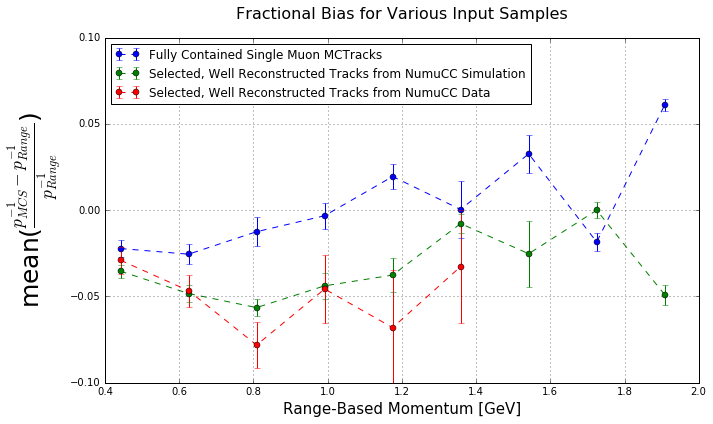

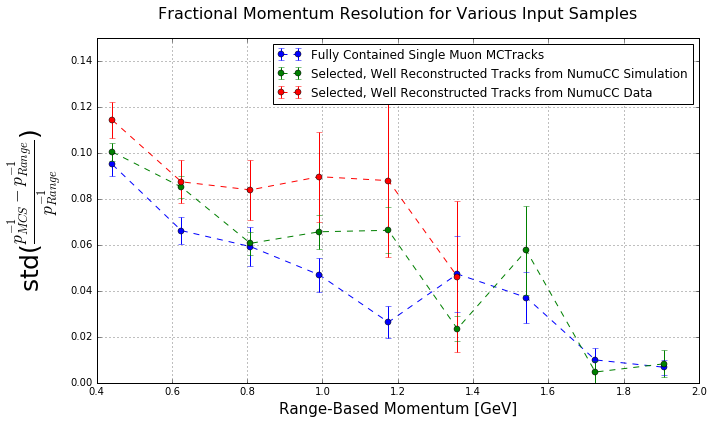

In [19]:
fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_multiplesamples.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_multiplesamples.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)

In [20]:
def fractional_resolution_plots(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( 2 * float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='%s' % titles[anatype])
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('MCS Momentum Resolution for Various Input Types',fontsize=16)
    t.set_y(1.04) 
    if write_figures:
        plt.tight_layout()
        print " Saving figure!",figdir+'MCS_range_resolution_multiplesamples.png'
        plt.savefig(figdir + 'MCS_range_resolution_multiplesamples.png')

 Saving figure! Figures/MCS_range_resolution_multiplesamples.png


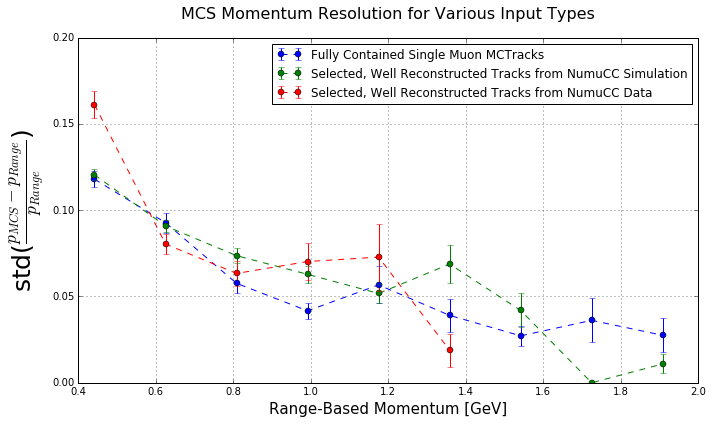

In [40]:
fractional_resolution_plots(xvar='full_range_momentum',xbins=np.linspace(0.35,2,10))
blah = plt.ylim((0,0.20))